In [2]:
import sys
sys.path.append('..')
from utils import *
import pandas as pd
import matplotlib as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error


class AntiChessNNet(nn.Module):
    def __init__(self, game, args):
        # game params
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()
        self.args = args

        super(AntiChessNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)
        self.conv4 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)

        self.bn1 = nn.BatchNorm2d(args.num_channels)
        self.bn2 = nn.BatchNorm2d(args.num_channels)
        self.bn3 = nn.BatchNorm2d(args.num_channels)
        self.bn4 = nn.BatchNorm2d(args.num_channels)

        self.fc1 = nn.Linear(args.num_channels*(self.board_x-4)*(self.board_y-4), 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.fc_bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, self.action_size)

        self.fc4 = nn.Linear(512, 1)

    def forward(self, s):
        #                                                           s: batch_size x board_x x board_y
        s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
        s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
        s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
        s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
        s = s.view(-1, self.args.num_channels*(self.board_x-4)*(self.board_y-4))

        s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
        s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

        pi = self.fc3(s)                                                                         # batch_size x action_size
        v = self.fc4(s)                                                                          # batch_size x 1

        return F.log_softmax(pi, dim=1), torch.tanh(v)


In [3]:
import os
import sys
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
from tqdm import tqdm

sys.path.append('../../')
from utils import *
from NeuralNet import NeuralNet

import torch
import torch.optim as optim


args = dotdict({
    'lr': 0.2,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})


class NNetWrapper(NeuralNet):
    def __init__(self, game):
        self.nnet = AntiChessNNet(game, args)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()

        if args.cuda:
            self.nnet.cuda()

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        optimizer = optim.Adam(self.nnet.parameters())

        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch + 1))
            self.nnet.train()
            pi_losses = AverageMeter()
            v_losses = AverageMeter()

            batch_count = int(len(examples) / args.batch_size)

            t = tqdm(range(batch_count), desc='Training Net')
            for _ in t:
                sample_ids = np.random.randint(len(examples), size=args.batch_size)
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = [board.pieces for board in boards]
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                if args.cuda:
                    boards, target_pis, target_vs = boards.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()

                # compute output
                out_pi, out_v = self.nnet(boards)
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                # record loss
                pi_losses.update(l_pi.item(), boards.size(0))
                v_losses.update(l_v.item(), boards.size(0))
                t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

    def predict(self, board):
        """
        board: np array with board
        """
        # timing

        # preparing input
        board = torch.FloatTensor(board.pieces.astype(np.float64))
        if args.cuda: board = board.contiguous().cuda()
        board = board.view(1, self.board_x, self.board_y)
        self.nnet.eval()
        with torch.no_grad():
            pi, v = self.nnet(board)

        # print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return torch.exp(pi).data.cpu().numpy()[0], v.data.cpu().numpy()[0]

    def loss_pi(self, targets, outputs):
        return -torch.sum(targets * outputs) / targets.size()[0]

    def loss_v(self, targets, outputs):
        return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("Checkpoint Directory does not exist! Making directory {}".format(folder))
            os.mkdir(folder)
        else:
            print("Checkpoint Directory exists! ")
        torch.save({
            'state_dict': self.nnet.state_dict(),
        }, filepath)

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            raise ("No model in path {}".format(filepath))
        map_location = None if args.cuda else 'cpu'
        checkpoint = torch.load(filepath, map_location=map_location)
        self.nnet.load_state_dict(checkpoint['state_dict'])


In [4]:
# https://stackoverflow.com/questions/2267362/how-to-convert-an-integer-in-any-base-to-a-string

import string

digs = string.digits + string.ascii_letters


def int2base(x, base, length):
    if x < 0:
        sign = -1
    elif x == 0:
        return digs[0]
    else:
        sign = 1

    x *= sign
    digits = []

    while x:
        digits.append(digs[int(x % base)])
        x = int(x / base)

    if sign < 0:
        digits.append('-')

    while len(digits) < length: digits.extend(["0"])

    return list(map(lambda x: int(x), digits))


FILE_MAP = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}
RANK_MAP = {'1': 7, '2': 6, '3': 5, '4': 4, '5': 3, '6': 2, '7': 1, '8': 0}

RESIDUALS_MAP = {0.875 : 7, 0.75 : 6, 0.625 : 5, 0.5 : 4,0.375 : 3, 0.25 : 2, 0.125 : 1, 0.0 : 0}
PIECE_MAP = {"r" : -4, "n" : -2, "b": -3, "q" : -5, "k" : -6, "p" : -1, "R" : 4, "N" : 2, "B": 3, "Q" : 5, "K" : 6, "P" : 1}

FILE_MAP_REVERSE = {v: k for k, v in FILE_MAP.items()}
RANK_MAP_REVERSE = {v: k for k, v in RANK_MAP.items()}

PIECE_MAP = {"p" : 1, "P" : -1, "R" : -4, "r" : 4, "N" : -2, "n" : 2, "B" : -3, "b" : 3, "Q" : -5, "q" : 5, "K" : -6, "k" : 6}


PROMOTIONS = {'a2a1q': 0,
             'a2a1r': 11,
             'a2a1k': 12,
             'a2a1b': 13,
             'a2a1n': 14,
             'a2b1q': 15,
             'a2b1r': 19,
             'a2b1k': 20,
             'a2b1b': 21,
             'a2b1n': 22,
             'a7a8q': 23,
             'a7a8r': 25,
             'a7a8k': 26,
             'a7a8b': 28,
             'a7a8n': 29,
             'a7b8q': 30,
             'a7b8r': 31,
             'a7b8k': 33,
             'a7b8b': 34,
             'a7b8n': 35,
             'b2a1q': 37,
             'b2a1r': 38,
             'b2a1k': 39,
             'b2a1b': 41,
             'b2a1n': 42,
             'b2b1q': 43,
             'b2b1r': 44,
             'b2b1k': 46,
             'b2b1b': 47,
             'b2b1n': 49,
             'b2c1q': 50,
             'b2c1r': 51,
             'b2c1k': 52,
             'b2c1b': 53,
             'b2c1n': 55,
             'b7a8q': 57,
             'b7a8r': 58,
             'b7a8k': 59,
             'b7a8b': 60,
             'b7a8n': 61,
             'b7b8q': 62,
             'b7b8r': 65,
             'b7b8k': 76,
             'b7b8b': 77,
             'b7b8n': 78,
             'b7c8q': 79,
             'b7c8r': 84,
             'b7c8k': 85,
             'b7c8b': 86,
             'b7c8n': 87,
             'c2b1q': 88,
             'c2b1r': 90,
             'c2b1k': 91,
             'c2b1b': 93,
             'c2b1n': 94,
             'c2c1q': 95,
             'c2c1r': 96,
             'c2c1k': 98,
             'c2c1b': 99,
             'c2c1n': 100,
             'c2d1q': 102,
             'c2d1r': 103,
             'c2d1k': 104,
             'c2d1b': 106,
             'c2d1n': 107,
             'c7b8q': 108,
             'c7b8r': 109,
             'c7b8k': 111,
             'c7b8b': 112,
             'c7b8n': 114,
             'c7c8q': 115,
             'c7c8r': 116,
             'c7c8k': 117,
             'c7c8b': 118,
             'c7c8n': 120,
             'c7d8q': 122,
             'c7d8r': 123,
             'c7d8k': 124,
             'c7d8b': 125,
             'c7d8n': 126,
             'd2c1q': 127,
             'd2c1r': 130,
             'd2c1k': 141,
             'd2c1b': 142,
             'd2c1n': 143,
             'd2d1q': 149,
             'd2d1r': 150,
             'd2d1k': 151,
             'd2d1b': 152,
             'd2d1n': 153,
             'd2e1q': 155,
             'd2e1r': 156,
             'd2e1k': 158,
             'd2e1b': 159,
             'd2e1n': 160,
             'd7c8q': 161,
             'd7c8r': 163,
             'd7c8k': 164,
             'd7c8b': 165,
             'd7c8n': 167,
             'd7d8q': 168,
             'd7d8r': 169,
             'd7d8k': 171,
             'd7d8b': 172,
             'd7d8n': 173,
             'd7e8q': 174,
             'd7e8r': 176,
             'd7e8k': 177,
             'd7e8b': 179,
             'd7e8n': 180,
             'e2d1q': 181,
             'e2d1r': 182,
             'e2d1k': 183,
             'e2d1b': 184,
             'e2d1n': 185,
             'e2e1q': 187,
             'e2e1r': 188,
             'e2e1k': 189,
             'e2e1b': 190,
             'e2e1n': 191,
             'e2f1q': 195,
             'e2f1r': 200,
             'e2f1k': 206,
             'e2f1b': 207,
             'e2f1n': 208,
             'e7d8q': 214,
             'e7d8r': 215,
             'e7d8k': 217,
             'e7d8b': 218,
             'e7d8n': 220,
             'e7e8q': 221,
             'e7e8r': 223,
             'e7e8k': 224,
             'e7e8b': 225,
             'e7e8n': 226,
             'e7f8q': 228,
             'e7f8r': 229,
             'e7f8k': 230,
             'e7f8b': 232,
             'e7f8n': 233,
             'f2e1q': 234,
             'f2e1r': 236,
             'f2e1k': 237,
             'f2e1b': 238,
             'f2e1n': 239,
             'f2f1q': 240,
             'f2f1r': 241,
             'f2f1k': 242,
             'f2f1b': 244,
             'f2f1n': 245,
             'f2g1q': 246,
             'f2g1r': 247,
             'f2g1k': 248,
             'f2g1b': 249,
             'f2g1n': 250,
             'f7e8q': 252,
             'f7e8r': 253,
             'f7e8k': 254,
             'f7e8b': 255,
             'f7e8n': 260,
             'f7f8q': 264,
             'f7f8r': 265,
             'f7f8k': 271,
             'f7f8b': 272,
             'f7f8n': 273,
             'f7g8q': 279,
             'f7g8r': 280,
             'f7g8k': 282,
             'f7g8b': 283,
             'f7g8n': 285,
             'g2f1q': 286,
             'g2f1r': 289,
             'g2f1k': 290,
             'g2f1b': 291,
             'g2f1n': 293,
             'g2g1q': 294,
             'g2g1r': 295,
             'g2g1k': 296,
             'g2g1b': 297,
             'g2g1n': 298,
             'g2h1q': 299,
             'g2h1r': 301,
             'g2h1k': 302,
             'g2h1b': 303,
             'g2h1n': 304,
             'g7f8q': 305,
             'g7f8r': 306,
             'g7f8k': 307,
             'g7f8b': 309,
             'g7f8n': 310,
             'g7g8q': 311,
             'g7g8r': 312,
             'g7g8k': 313,
             'g7g8b': 314,
             'g7g8n': 315,
             'g7h8q': 317,
             'g7h8r': 318,
             'g7h8k': 319,
             'g7h8b': 325,
             'g7h8n': 328,
             'h2g1q': 329,
             'h2g1r': 330,
             'h2g1k': 336,
             'h2g1b': 337,
             'h2g1n': 338,
             'h2h1q': 344,
             'h2h1r': 345,
             'h2h1k': 347,
             'h2h1b': 348,
             'h2h1n': 350,
             'h7g8q': 351,
             'h7g8r': 352,
             'h7g8k': 354,
             'h7g8b': 355,
             'h7g8n': 356,
             'h7h8q': 358,
             'h7h8r': 359,
             'h7h8k': 361,
             'h7h8b': 362,
             'h7h8n': 363}

REVERSE_PROMOTIONS = {v: k for k, v in PROMOTIONS.items()}

def get_move_from_action(action):    
    if action in REVERSE_PROMOTIONS:
        move = REVERSE_PROMOTIONS[action]

    else:
        move = int2base(action, 8, 4)
        move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]
        
    return move

In [5]:
import os
import sys
import time

import numpy as np
from tqdm import tqdm

sys.path.append('../../')
from utils import *
from NeuralNet import NeuralNet

import torch
import torch.optim as optim

args = dotdict({
    'lr': 0.01,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
})


class NNetWrapper(NeuralNet):
    def __init__(self, game):
        self.nnet = AntiChessNNet(game, args)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()

        if args.cuda:
            self.nnet.cuda()

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        optimizer = optim.Adam(self.nnet.parameters())

        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch + 1))
            self.nnet.train()
            pi_losses = AverageMeter()
            v_losses = AverageMeter()

            batch_count = int(len(examples) / args.batch_size)

            t = tqdm(range(batch_count), desc='Training Net')
            for _ in t:
                sample_ids = np.random.randint(len(examples), size=args.batch_size)
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = [board.pieces for board in boards]
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                if args.cuda:
                    boards, target_pis, target_vs = boards.contiguous().cuda(), target_pis.contiguous().cuda(), target_vs.contiguous().cuda()

                # compute output
                out_pi, out_v = self.nnet(boards)
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                # record loss
                pi_losses.update(l_pi.item(), boards.size(0))
                v_losses.update(l_v.item(), boards.size(0))
                t.set_postfix(Loss_pi=pi_losses, Loss_v=v_losses)

                # compute gradient and do SGD step
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

    def predict(self, board):
        """
        board: np array with board
        """
        # timing

        # preparing input
        board = torch.FloatTensor(board.pieces.astype(np.float64))
        if args.cuda: board = board.contiguous().cuda()
        board = board.view(1, self.board_x, self.board_y)
        self.nnet.eval()
        with torch.no_grad():
            pi, v = self.nnet(board)

        # print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return torch.exp(pi).data.cpu().numpy()[0], v.data.cpu().numpy()[0]

    def loss_pi(self, targets, outputs):
        return -torch.sum(targets * outputs) / targets.size()[0]

    def loss_v(self, targets, outputs):
        return torch.sum((targets - outputs.view(-1)) ** 2) / targets.size()[0]

    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("Checkpoint Directory does not exist! Making directory {}".format(folder))
            os.mkdir(folder)
        else:
            print("Checkpoint Directory exists! ")
        torch.save({
            'state_dict': self.nnet.state_dict(),
        }, filepath)

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
        # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            raise ("No model in path {}".format(filepath))
        map_location = None if args.cuda else 'cpu'
        checkpoint = torch.load(filepath, map_location=map_location)
        self.nnet.load_state_dict(checkpoint['state_dict'])


In [6]:
import logging
import os
import sys
from collections import deque
from pickle import Pickler, Unpickler
from random import shuffle

import numpy as np
from tqdm import tqdm

from Arena import Arena
from datetime import datetime

log = logging.getLogger(__name__)

import chess.pgn
import time

class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()
        
        self.time_mcts = 0
        self.time_nnet = 0
        self.time_nmcts = 0
        self.time_pmcts = 0
        self.time_play = 0


    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

    
        while True:

            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)

            sym = self.game.getSymmetries(canonicalBoard, pi)
            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
           
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)

            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            log.info(f'Starting Iter #{i} ...')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="Self Play"):
                    #self.mcts = MCTS(self.game, self.nnet, self.args)  # reset search tree
                    self.mcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history
                self.trainExamplesHistory.append(iterationTrainExamples)
                
                
            print("Ns:",len(self.mcts.Ns))
            print("Nsa:",len(self.mcts.Nsa))
            print("Ps:",len(self.mcts.Ps))
            print("Qsa:",len(self.mcts.Qsa))
            print("Es:",len(self.mcts.Es))
            print("Vs:",len(self.mcts.Vs))


            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                log.warning(
                    f"Removing the oldest entry in trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)
            self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)

            # training new network, keeping a copy of the old one
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='checkpoint_'+str(i)+'.pth.tar')
            self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            pmcts = MCTS(self.game, self.pnet, self.args, dirichlet_noise=True)

            start = time.time()
            self.nnet.train(trainExamples)
            end = time.time()
            self.time_nnet += (end - start)
            nmcts = MCTS(self.game, self.nnet, self.args, dirichlet_noise=True)

            log.info('PITTING AGAINST PREVIOUS VERSION')
            arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
                          lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
            
            start = time.time()
            pwins, nwins, draws = arena.playGames(self.args.arenaCompare)
            end = time.time()
            self.time_play += (end-start)

            
            self.time_mcts = self.mcts.time_sims + self.mcts.time_vali + self.mcts.time_next + self.mcts.time_pick + self.mcts.time_diri
            self.time_nmcts = nmcts.time_sims + nmcts.time_vali + nmcts.time_next + nmcts.time_pick + nmcts.time_diri
            self.time_pmcts = pmcts.time_sims + pmcts.time_vali + pmcts.time_next + pmcts.time_pick + pmcts.time_diri
                
            print("nmcts_time:",self.time_nmcts)
            print("pmcts_time:",self.time_pmcts)
            print("trai_time:",self.time_nnet)
            print("mcts_time:",self.time_mcts)
            print("play_time:",self.time_play)

            
            print("mdiri_time:",self.mcts.time_diri)
            print("msims_time:",self.mcts.time_sims)
            print("mvali_time:",self.mcts.time_vali)
            print("mnext_time:",self.mcts.time_next)
            print("mpick_time:",self.mcts.time_pick)
            print("mnnet_time:",self.mcts.time_nnet)

            
            print("ndiri_time:",nmcts.time_diri)
            print("nsims_time:",nmcts.time_sims)
            print("nvali_time:",nmcts.time_vali)
            print("nnext_time:",nmcts.time_next)
            print("npick_time:",nmcts.time_pick)
            print("nnnet_time:",nmcts.time_nnet)
            
            print("pdiri_time:",pmcts.time_diri)
            print("psims_time:",pmcts.time_sims)
            print("pvali_time:",pmcts.time_vali)
            print("pnext_time:",pmcts.time_next)
            print("ppick_time:",pmcts.time_pick)
            print("pnnet_time:",pmcts.time_nnet)



            log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
            if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
                log.info('REJECTING NEW MODEL')
                self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            else:
                log.info('ACCEPTING NEW MODEL')
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')

    def getCheckpointFile(self, iteration):
        return 'checkpoint_' + str(iteration) + '.pth.tar'

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            log.warning(f'File "{examplesFile}" with trainExamples not found!')
            r = input("Continue? [y|n]")
            if r != "y":
                sys.exit()
        else:
            log.info("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            log.info('Loading done!')

            print("examples:",sum([len(hist) for hist in self.trainExamplesHistory]))

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

In [7]:
import logging
import math
import time

import numpy as np
EPS = 1e-8

log = logging.getLogger(__name__)

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args, dirichlet_noise=False):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.dirichlet_noise = dirichlet_noise
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s
        
        self.time_sims = 0
        
        self.time_nnet = 0
        self.time_vali = 0
        self.time_next = 0
        self.time_diri = 0
        self.time_pick = 0

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        
        
        start = time.time()
        
        for i in range(self.args.numMCTSSims):
            dir_noise = (i == 0 and self.dirichlet_noise)
            self.search(canonicalBoard,depth=0, dirichlet_noise=dir_noise)

        end = time.time()
        self.time_sims += (end - start)


        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
        
        

       

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard,depth, dirichlet_noise=False):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """


        s = self.game.stringRepresentation(canonicalBoard)
        
        if canonicalBoard.board.is_fifty_moves() or canonicalBoard.board.is_fivefold_repetition():
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
            if self.Es[s] != 0:
                    # terminal node
                return -self.Es[s]
                
        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]


        if s not in self.Ps:
            # leaf node
            
            start = time.time()
            self.Ps[s], v = self.nnet.predict(canonicalBoard)
            end = time.time()
            self.time_nnet += (end - start)
            
            start = time.time()
            valids = self.game.getValidMoves(canonicalBoard, 1)

            end = time.time()
            self.time_vali += (end - start)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            
            start = time.time()
            if self.dirichlet_noise:
                self.applyDirNoise(s, valids)
                
            end = time.time()
            self.time_diri += (end - start)
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
                log.error("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        start = time.time()
        if self.dirichlet_noise:
            self.applyDirNoise(s, valids)
            sum_Ps_s = np.sum(self.Ps[s])
            self.Ps[s] /= sum_Ps_s      # renormalize
        end = time.time()
        self.time_diri += (end - start)
        cur_best = -float('inf')
        best_act = -1

        
        # pick the action with the highest upper confidence bound
        start = time.time()
        #for a in range(self.game.getActionSize()):
         #   if valids[a]:
        for a in np.argwhere(valids):
            a = a[0]
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])

                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a
                    
        end = time.time()
        self.time_pick += (end - start)

        a = best_act

        start = time.time()
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        end = time.time()
        self.time_next += (end - start)
        next_s = self.game.getCanonicalForm(next_s, next_player)
        v = self.search(next_s,depth=depth+1)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1

        return -v
    
    def applyDirNoise(self, s, valids):
        dir_values = np.random.dirichlet([self.args.dirichletAlpha] * np.count_nonzero(valids))
        dir_idx = 0
        s_policy = self.Ps[s]
        s_policy = np.argwhere(s_policy) #optimization
        #for idx in range(len(self.Ps[s])):
        for idx in s_policy:
            idx = idx[0]
            if self.Ps[s][idx]:
                self.Ps[s][idx] = (0.75 * self.Ps[s][idx]) + (0.25 * dir_values[dir_idx])
                dir_idx += 1

In [8]:
'''
Board class for the game of AntiChessGame.

pieces[0][0] is the top left square,
pieces[7][0] is the bottom left square,

'''

import sys
import numpy as np
import chess.variant
import chess.pgn
from antichess3.Digits import *
import random

class Board():

    def __init__(self):
        self.board = chess.variant.AntichessBoard()
        self.board.set_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1")
        #self.board.set_fen("r3k2r/p2p3p/8/q7/Q7/8/P2P3P/R3K2R w - - 0 1")
        self.pieces = np.zeros((8, 8)).astype(int)
        self.n = 8
        self.from_piece_map_to_pieces()

    def __str__(self):
        return str(self.get_player_to_move()) + ''.join(str(r) for v in self.pieces for r in v)

    def getCopy(self):
        b = Board()
        b.board = self.board.copy()
        b.pieces = np.copy(np.array(self.pieces))
        return b
    
    def set_fen(self,fen):
        self.board.set_fen(fen)

    def get_player_to_move(self):

        if self.board.turn:
            return "white"
        else:
            return "black"

    def get_legal_moves(self):
        moves = []
        for move in self.board.legal_moves:
            moves.append(list(str(move)))

        return moves

    def execute_move(self, move, color):
        """Perform the given move on the board.
        color gives the color pf the piece to play (1=white,-1=black)
        """

        # print(self.board.fen(),move,self.board.is_fifty_moves())
        try:
            self.board.push_uci(move)
            self.from_piece_map_to_pieces()
        except Exception as e:
            print(e)
            #print(move)

            action = 0
            if len(move) > 4:  # if promotion move, we map moves differently
                action = PROMOTIONS["".join(move)]
            else:
                x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
                action = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3
            #print(self.board.fen())

            valids = [0] * 4096
            legalMoves = self.get_legal_moves()

            # need to optimize
            for move in legalMoves:
                if len(move) > 4:  # if promotion move, we map moves differently
                    valid_index = PROMOTIONS["".join(move)]
                    valids[valid_index] = 1
                else:
                    x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
                    valids[x1 + y1 * self.n + x2 * self.n ** 2 + y2 * self.n ** 3] = 1

            if valids[action] == 0:
                valid_actions = np.where(np.array(valids) == 1)
                action = random.choice(valid_actions[0])

                move = "a1a1"
                if action in REVERSE_PROMOTIONS:
                    move = REVERSE_PROMOTIONS[action]

                else:
                    move = int2base(action, 8, 4)
                    move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[
                        move[2]] + "" + RANK_MAP_REVERSE[move[3]]

                print("move randomly chosen:", move)
                self.board.push_uci(move)
                self.from_piece_map_to_pieces()

    # need to optimze
    def from_piece_map_to_pieces(self):

        square_at_index = 0
        for i in reversed(range(0, 8)):
            for j in range(0, 8):
                try:
                    color = self.board.piece_at(square=square_at_index).color
                    piece_type = self.board.piece_at(square=square_at_index).piece_type
                    if color == False:
                        piece_type = piece_type * (-1)
                except:
                    piece_type = 0
                self.pieces[i][j] = piece_type
                square_at_index = square_at_index + 1


In [9]:
import sys
import numpy as np
sys.path.append('..')
from Game import Game


class AntiChessGame(Game):
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """

    def __init__(self,n,fen):
        self.n = n
        self.board = self.getInitBoard()
        self.board.board.set_fen(fen)
        

    def getInitBoard(self):
        """
        Returns:
            startBoard: a representation of the board (ideally this is the form
                        that will be the input to your neural network)
        """
        board = Board()
        return board


    def getBoardSize(self):
        """
        Returns:
            (x,y): a tuple of board dimensions
        """
        return (self.n,self.n)

    def getActionSize(self):
        """
        Returns:
            actionSize: number of all possible actions
        """
        return self.n ** 4

    def getNextState(self, board, player, action):
        """
        Input:
            board: current board
            player: current player (1 or -1)
            action: action taken by current player
        Returns:
            nextBoard: board after applying action
            nextPlayer: player who plays in the next turn (should be -player)
        """


        b = board.getCopy()

        if action in REVERSE_PROMOTIONS:
            move = REVERSE_PROMOTIONS[action]

        else:
            move = int2base(action, self.n, 4)
            move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]

        b.execute_move(move, player)
        return (b, -player)


    def getValidMoves(self, board, player):
        """
        Input:
            board: current board
            player: current player
        Returns:
            validMoves: a binary vector of length self.getActionSize(), 1 for
                        moves that are valid from the current board and player,
                        0 for invalid moves
        """

        valids = [0] * self.getActionSize()
        b = board.getCopy()
        legalMoves = b.get_legal_moves()

        #need to optimize
        for move in legalMoves:
            if len(move) > 4: #if promotion move, we map moves differently
                valid_index = PROMOTIONS["".join(move)]

                valids[valid_index] = 1
            else:
                x1, y1, x2, y2 =  FILE_MAP[move[0]],RANK_MAP[move[1]],FILE_MAP[move[2]],RANK_MAP[move[3]]
                valids[x1 + y1 * b.n + x2 * b.n ** 2 + y2 * b.n ** 3] = 1

        return np.array(valids)

    def getGameEnded(self, board, player):
        """
        Input:
            board: current board
            player: current player (1 or -1)
        Returns:
            r: 0 if game has not ended. 1 if player won, -1 if player lost,
               small non-zero value for draw.

        """

        b = board.getCopy()

        if b.board.is_fivefold_repetition():
            #print("five fold")
            return 0.0001

        if b.board.is_fifty_moves():
            #print("fifty")
            return 0.0001

        if b.board.is_game_over():

            result = b.board.outcome().result().split("-")
            if result[0] == "1":
                return 1 if b.board.turn else -1
            elif result[0] == "0":
                return -1 if b.board.turn else 1
            else:
                return 0.0001

        else:
            return 0

    def getCanonicalForm(self, board, player):
        b = board.getCopy()
        # rules and objectives are different for the different players, so inverting board results in an invalid state.
        return b

    def getSymmetries(self, board, pi):

        """
        Input:
            board: current board
            pi: policy vector of size self.getActionSize()
        Returns:
            symmForms: a list of [(board,pi)] where each tuple is a symmetrical
                       form of the board and the corresponding pi vector. This
                       is used when training the neural network from examples.
        """
        return [(board, pi)]


    def stringRepresentation(self, board):
        """
        Input:
            board: current board
        Returns:
            boardString: a quick conversion of board to a string format.
                         Required by MCTS for hashing.
        """
        board_s = board.board.fen().split(" ")
        board_s = board_s[0] + board_s[1] + board_s[3]
        return board_s

In [10]:
import numpy as np
import chess.engine
import chess.variant
from antichess3.Digits import *

class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a] != 1:
            a = np.random.randint(self.game.getActionSize())

        return a


class HumanAntiChessPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        # display(board)
        valid = self.game.getValidMoves(board, 1)
        while True:
            a = input()
            x1,y1,x2,y2 = [int(x) for x in a.strip().split(' ')]
            a = x1 + y1 * self.game.n + x2 * self.game.n**2 + y2 * self.game.n**3
            if valid[a]:
                break
            else:
                print('Invalid')


        return a

class StockFishPlayer():
    def __init__(self,game,time,skill_lvl):
        self.game = game
        self.time = time
        self.engine = chess.engine.SimpleEngine.popen_uci("C:/Users/jerne/Downloads/fairy-stockfish-largeboard_x86-64.exe")
        self.engine.configure({"Skill Level": skill_lvl})
        
    def play(self,board):

        result = self.engine.play(board.board, chess.engine.Limit(time=self.time))
        move = str(result.move)

        a = 0
        if len(move) > 4:  # if promotion move, we map moves differently
            a = PROMOTIONS["".join(move)]
        else:
            x1, y1, x2, y2 = FILE_MAP[move[0]], RANK_MAP[move[1]], FILE_MAP[move[2]], RANK_MAP[move[3]]
            a = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3

        return a
    
    def close_engine(self):
        self.engine.quit()

In [11]:
def get_move_from_action(action):    
    if action in REVERSE_PROMOTIONS:
        move = REVERSE_PROMOTIONS[action]

    else:
        move = int2base(action, 8, 4)
        move = FILE_MAP_REVERSE[move[0]]+""+RANK_MAP_REVERSE[move[1]]+""+FILE_MAP_REVERSE[move[2]]+""+RANK_MAP_REVERSE[move[3]]
        
    return move

In [12]:
def get_action_from_move(move):

    x1, y1, x2, y2 = FILE_MAP[move[0]],RANK_MAP[move[1]],FILE_MAP[move[2]],RANK_MAP[move[3]]
    action = x1 + y1 * 8 + x2 * 8 ** 2 + y2 * 8 ** 3
    
    return action

In [12]:
import logging

import coloredlogs

from Arena import *
from utils import *

log = logging.getLogger(__name__)

coloredlogs.install(level='INFO')  # Change this to DEBUG to see more info.

args1 = dotdict({
    'numIters': 1,
    'numEps': 10,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 25,        #
    'updateThreshold': 0.60,    # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'numMCTSSims': 10,          # Number of games moves for MCTS to simulate.
    'arenaCompare': 4,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1.25,
    'dirichletAlpha': 0.1,     # α = {0.3, 0.15, 0.03} for chess, shogi and Go respectively, scaled in inverse proportion to the approximate number of legal moves in a typical position
    'checkpoint': './temp/antichess/final/torch/test/',
    'load_model': False,
    'load_folder_file': ('./temp/antichess/final/torch/test/','checkpoint_1.pth.tar'),
    'numItersForTrainExamplesHistory': 20,

})


log.info('Loading %s...', Game.__name__)
g = AntiChessGame(8)

log.info('Loading %s...', nn.__name__)
nnet = NNetWrapper(g)

if args1.load_model:
    log.info('Loading checkpoint "%s/%s"...', args1.load_folder_file[0],args1.load_folder_file[1])
    nnet.load_checkpoint(args1.load_folder_file[0], args1.load_folder_file[1])
else:
    log.warning('Not loading a checkpoint!')

log.info('Loading the Coach...')
c = Coach(g, nnet, args1)

if args1.load_model:
    log.info("Loading 'trainExamples' from file...")
    c.loadTrainExamples()

log.info('Starting the learning process 🎉')
#c.learn()



2021-12-12 18:56:20 DESKTOP-P47V2S9 __main__[6432] INFO Loading Game...


TypeError: __init__() missing 1 required positional argument: 'fen'

In [13]:
def from_piece_map_to_pieces():

    square_at_index = 0
    for i in reversed(range(0, 8)):
        for j in range(0, 8):
            try:
                color = board.piece_at(square=square_at_index).color
                piece_type = board.piece_at(square=square_at_index).piece_type
                if color == False:
                    piece_type = piece_type * (-1)
            except:
                piece_type = 0
            pieces[i][j] = piece_type
            square_at_index = square_at_index + 1

In [14]:
import logging
import numpy as np
import random
from tqdm import tqdm
import chess
import chess.pgn
            

log = logging.getLogger(__name__)


class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2,game,fen,games_file,display=None):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it (e.g.
                     display in othello/OthelloGame). Is necessary for verbose
                     mode.
        see othello/OthelloPlayers.py for an example. See pit.py for pitting
        human players/other baselines with each other.
        """
        
        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.display = display
        self.mean_centi_pawn_loss_player1 = []
        self.mean_centi_pawn_loss_player2 = []
        self.blunders_player1 = []
        self.blunders_player2 = []
        self.stockfish_analysis_thinking_time = 0.01
        self.fen = fen
        self.game_to_write = open(games_file,"w")

        
    def set_analysis_thinking_time(self,time):
        self.stockfish_analysis_thinking_time = time


    def playGame(self, verbose=True):
        """
        Executes one episode of a game.
        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """

        engine = chess.engine.SimpleEngine.popen_uci("C:/Users/jerne/Downloads/fairy-stockfish-largeboard_x86-64.exe")
        centi_pawn_loss_player1 = []
        centi_pawn_loss_player2 = []

        players = [self.player2, None, self.player1]
        curPlayer = 1
        board = self.game.getInitBoard()
        board.set_fen(self.fen)
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                assert self.display
                print("Turn ", str(it), "Player ", str(curPlayer))
                self.display(board)
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))
                        
            possible_moves = self.get_move_evaluation(engine, board.board, time_per_move=self.stockfish_analysis_thinking_time)

            if players[curPlayer + 1] == self.player1:
                move_centi_pawn = possible_moves[self.get_move_from_action(action)]
                best_centi_pawn = possible_moves[(max(possible_moves, key=possible_moves.get))]
                centi_pawn_diff_player1 = move_centi_pawn - best_centi_pawn
                if centi_pawn_diff_player1 < -100000:
                    self.blunders_player1.append(centi_pawn_diff_player1)
                    centi_pawn_diff_player1 = 0 # if blunder we set it to 0
                centi_pawn_loss_player1.append(centi_pawn_diff_player1)

            else:
                move_centi_pawn = possible_moves[self.get_move_from_action(action)]
                best_centi_pawn = possible_moves[(max(possible_moves, key=possible_moves.get))]
                centi_pawn_diff_player2 = move_centi_pawn - best_centi_pawn
                if centi_pawn_diff_player2 < -100000:
                    self.blunders_player2.append(centi_pawn_diff_player2)
                    centi_pawn_diff_player2 = 0 # if blunder we set it to 0
                centi_pawn_loss_player2.append(centi_pawn_diff_player2)


            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)

            #hack, that needs to be removed
            if valids[action] == 0:
                print("HACK")
                valid_actions = np.where(valids == 1)
                action = random.choice(valid_actions[0])

            if valids[action] == 0:

                print(valids)
                print(action)
                print(board.pieces)
                print(board.board.fen())
                print(curPlayer)
                move = int2base(action, 8, 4)
                move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[move[2]] + "" + RANK_MAP_REVERSE[move[3]]
                print(move)
                moves1 = []
                for move1 in board.board.legal_moves:
                    moves1.append(list(str(move1)))
                print(moves1)
                log.error(f'Action {action} is not valid!')
                log.debug(f'valids = {valids}')
                assert valids[action] > 0
            board, curPlayer = self.game.getNextState(board, curPlayer, action)
        if verbose:
            assert self.display
            print("Game over: Turn ", str(it), "Result ", str(self.game.getGameEnded(board, 1)))
            self.display(board)

        engine.quit()
        #print("player1 avg_cpl:", np.mean(centi_pawn_loss_player1))
        #print("player2 avg_cpl:", np.mean(centi_pawn_loss_player2))
        self.mean_centi_pawn_loss_player1.append(np.mean(centi_pawn_loss_player1))
        self.mean_centi_pawn_loss_player2.append(np.mean(centi_pawn_loss_player2))
        game_pgn = chess.pgn.Game().from_board(board.board)
        #print(game_pgn)
        self.game_to_write.write("\n\n"+str(game_pgn)+"\n\n")
    
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, num, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.
        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(num / 2)
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (1)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1

        self.player1, self.player2 = self.player2, self.player1
        self.mean_centi_pawn_loss_player1, self.mean_centi_pawn_loss_player2 = self.mean_centi_pawn_loss_player2, self.mean_centi_pawn_loss_player1
        self.blunders_player1, self.blunders_player2 = self.blunders_player2,self.blunders_player1
        
        for _ in tqdm(range(num), desc="Arena.playGames (2)"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        print("total player1 avg_cpl:", np.mean(self.mean_centi_pawn_loss_player2))
        print("total player2 avg_cpl:", np.mean(self.mean_centi_pawn_loss_player1))
        self.game_to_write.close()
        return oneWon, twoWon, draws

    def get_move_evaluation(self,engine, board, time_per_move=0.01):
        list_moves = []
        for el in board.legal_moves:
            info = engine.analyse(board, chess.engine.Limit(time=time_per_move), root_moves=[el])
            t = str(info["score"])
            list_moves.append((str(el), info["score"].pov(board.turn).score(mate_score=1000000)))

        sorted_list_moves = sorted(list_moves, key=lambda x: x[1], reverse=True)
 
        return dict(sorted_list_moves)

    def get_move_from_action(self,action):
        if action in REVERSE_PROMOTIONS:
            move = REVERSE_PROMOTIONS[action]

        else:
            move = int2base(action, 8, 4)
            move = FILE_MAP_REVERSE[move[0]] + "" + RANK_MAP_REVERSE[move[1]] + "" + FILE_MAP_REVERSE[move[2]] + "" + \
                   RANK_MAP_REVERSE[move[3]]

        return move

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
def myFunc(e):
    try:
        model_index = int(e.split(".")[0].split("_")[-1])
    except:
        model_index = 201
    return model_index

In [16]:
def testing_agents(agent1_name,
                   agent2_name,
                   fen,
                   model_type,
                   num_of_games,
                   num_mcsts,
                   cpuct,
                   temp,
                   model,
                   stockfish_thinking_time,
                   stockfish_analysis_thinking_time,
                   random,
                   skill_lvl,
                   iteration):
    
            print(agent1_name,agent2_name,num_mcsts,stockfish_thinking_time,iteration,skill_lvl)

            player1_names = []
            player2_names = []
            games_per_iter = []
            player1_wins = []
            player2_wins = []
            draws = []
            player1_blunders = []
            player2_blunders = []
            centipawn_loss_player1 = []
            centipawn_loss_player2 = []
            time_per_iter = []
            
            alphaZeroType = ""
            agent1,agent2 = None,None
            results_name = ""
            games_file_name = ""
            
            g = AntiChessGame(8,fen)
            n1 = NNetWrapper(g)
            
            if model_type == "Final":
                alphaZeroType = "Final"
                n1.load_checkpoint('./temp/antichess/final/torch/',model)
            else:
                alphaZeroType = "Reduced"
                n1.load_checkpoint('./temp/antichess/reduced_moves/torch/2bqk1nr1p1ppp1p881P1PPP1P82BQK1NR/',model)


                
            args1 = dotdict({'numMCTSSims': num_mcts, 'cpuct':cpuct})
            mcts1 = MCTS(g, n1, args1)
            agent1 = lambda x: np.argmax(mcts1.getActionProb(x, temp=temp))
               
           
            if random:
                agent2 = RandomPlayer(g).play
                results_name = "./results/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"SkillLevel="+str(skill_lvl)+"vsRandomPlayerRESULTS.txt"
                games_file_name = "./games/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"SkillLevel="+str(skill_lvl)+"vsRandomPlayerGAMES.txt"
            else:
                agent2 = StockFishPlayer(g,stockfish_thinking_time,skill_lvl).play
                results_name = "./results/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfisTime="+str(stockfish_thinking_time)+"SkillLevel="+str(skill_lvl)+"RESULTS.txt"
                games_file_name = "./games/Type="+alphaZeroType+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcsts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfishTime="+str(stockfish_thinking_time)+"SkillLevel="+str(skill_lvl)+"GAMES.txt"


            arena = Arena(player1=agent1,player2=agent2,game=g,fen=fen,games_file=games_file_name)
            arena.set_analysis_thinking_time(stockfish_analysis_thinking_time)

            start = time.time()
            results = arena.playGames(num_of_games,verbose=False)

            end = time.time()
            print(end-start)
            time_per_iter.append(end-start)
            games_per_iter.append(num_of_games)
            player1_wins.append(results[0])
            player2_wins.append(results[1])
            draws.append(results[2])
            player1_names.append(agent1_name)
            player2_names.append(agent2_name)
            centipawn_loss_player1.append(np.mean(arena.mean_centi_pawn_loss_player2))
            centipawn_loss_player2.append(np.mean(arena.mean_centi_pawn_loss_player1))
            player2_blunders.append(len(arena.blunders_player1))
            player1_blunders.append(len(arena.blunders_player2))

            results_df = pd.DataFrame({"iteration" : iteration,
                                       "number_of_games" : games_per_iter,
                                       "time_per_iter":time_per_iter,
                                       "player1name":agent1_name,
                                       "player2name":agent2_name,
                                       "model" : model,
                                       "#MCTS" : num_mcts,
                                       "cpuct" : cpuct,
                                       "temp" : temp,
                                       "StockfishTime" : stockfish_thinking_time,
                                       "SkillLevel" : skill_lvl,
                                       "player1_wins" : player1_wins,
                                       "player2_wins":player2_wins,
                                       "draws" : draws,
                                       "centipawn_loss_player1": centipawn_loss_player1,
                                       "centipawn_loss_player2": centipawn_loss_player2,
                                       "blunders_player1" : player1_blunders, 
                                       "blunders_player2" : player2_blunders})    
            
            results_df.to_csv(results_name)


In [19]:
#PLAYING GAMES
mcts_sims = [150]
stockfish_thinking_times = [0.001]
skill_levels = [5]
cpucts = [1.0]
temps = [0]
agent1_name = "AlphaZero"
agent2_name = "Stockfish"
fen = "2bqk1nr/8/pppppppp/8/8/PPPPPPPP/8/2BQK1NR w - - 0 1"
model_type = "Reduced"
num_of_games = 20
stockfish_analysis_thinking_time = 0.01
random = False



for model in models[778:]:
    for num_mcts in mcts_sims:
        for stockfish_thinking_time in stockfish_thinking_times:
            for cpuct in cpucts:
                for temp in temps:
                    for skill_lvl in skill_levels:
                        iteration = 0
                        testing_agents(agent1_name=agent1_name,
                                       agent2_name=agent2_name,
                                       fen=fen,
                                       model_type=model_type,
                                       num_of_games=num_of_games,
                                       num_mcsts=num_mcts,
                                       cpuct=cpuct,
                                       temp=temp,
                                       model=model,
                                       stockfish_thinking_time=stockfish_thinking_time,
                                       stockfish_analysis_thinking_time=stockfish_analysis_thinking_time,
                                       random=random,
                                       skill_lvl=skill_lvl,
                                       iteration=iteration)
                        

AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.27s/it]


total player1 avg_cpl: -47.41745591976822
total player2 avg_cpl: -62.61402087773655
300.6749348640442
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]


total player1 avg_cpl: -58.28690321819039
total player2 avg_cpl: -41.452061197008454
269.183465719223
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.25s/it]


total player1 avg_cpl: -53.16798187257359
total player2 avg_cpl: -47.42210392679365
288.6019561290741
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.25s/it]


total player1 avg_cpl: -53.87196214038512
total player2 avg_cpl: -41.687213734909164
380.536199092865
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.54s/it]


total player1 avg_cpl: -45.257508093817236
total player2 avg_cpl: -39.0469422807155
265.608359336853
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.56s/it]


total player1 avg_cpl: -49.74170102352216
total player2 avg_cpl: -36.96650755694767
338.26457142829895
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.89s/it]


total player1 avg_cpl: -70.96355334601422
total player2 avg_cpl: -50.273208874458874
277.6453413963318
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:37<00:00, 15.74s/it]


total player1 avg_cpl: -46.98072106376445
total player2 avg_cpl: -34.77038372528871
321.6079399585724
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.82s/it]


total player1 avg_cpl: -48.89873375259198
total player2 avg_cpl: -45.65147645970586
395.0430076122284
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.93s/it]


total player1 avg_cpl: -54.037911138139464
total player2 avg_cpl: -46.70894749363983
249.9321231842041
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:26<00:00, 14.70s/it]


total player1 avg_cpl: -45.80994437841106
total player2 avg_cpl: -38.00503567790139
347.8845245838165
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:08<00:00, 12.88s/it]


total player1 avg_cpl: -47.27099344562386
total player2 avg_cpl: -45.55330151358789
275.6542491912842
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.21s/it]


total player1 avg_cpl: -52.48307873069484
total player2 avg_cpl: -39.351709076190495
343.1278557777405
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2):  90%|███████████████████████████████████████████████████████▊      | 9/10 [03:04<00:26, 26.08s/it]2021-12-03 12:12:04 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-03 12:12:07 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-03 12:12:07 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.01s/it]


total player1 avg_cpl: -48.83907662943085
total player2 avg_cpl: -48.72856396910357
407.9306356906891
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.36s/it]


total player1 avg_cpl: -53.567087118422705
total player2 avg_cpl: -40.57773314125364
477.3963031768799
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.76s/it]


total player1 avg_cpl: -48.210601399052436
total player2 avg_cpl: -47.495842582762904
297.3458561897278
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.08s/it]


total player1 avg_cpl: -47.94446879312578
total player2 avg_cpl: -42.24656239815981
413.68345737457275
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.99s/it]


total player1 avg_cpl: -43.948430428533754
total player2 avg_cpl: -39.77206099461104
346.92877554893494
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.95s/it]


total player1 avg_cpl: -37.79082853142837
total player2 avg_cpl: -38.09984437102859
294.83896946907043
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:20<00:00, 20.01s/it]


total player1 avg_cpl: -45.14148105062965
total player2 avg_cpl: -41.54345013751504
357.6291460990906
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.74s/it]


total player1 avg_cpl: -56.767849925421935
total player2 avg_cpl: -44.71417872465885
325.58153772354126
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.42s/it]


total player1 avg_cpl: -49.29644945515381
total player2 avg_cpl: -36.7160981841761
383.75833773612976
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [04:08<00:00, 24.82s/it]


total player1 avg_cpl: -61.39889289915529
total player2 avg_cpl: -41.12248342794704
425.4272789955139
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.41s/it]


total player1 avg_cpl: -54.06194759806334
total player2 avg_cpl: -41.31564111084197
507.637104511261
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.65s/it]


total player1 avg_cpl: -39.819914522268235
total player2 avg_cpl: -47.847904770882714
307.6443965435028
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.87s/it]


total player1 avg_cpl: -58.7512778335972
total player2 avg_cpl: -57.07945608971924
352.49242305755615
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [04:32<00:00, 27.29s/it]


total player1 avg_cpl: -48.15920185044329
total player2 avg_cpl: -37.92352990548037
483.7735204696655
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.27s/it]


total player1 avg_cpl: -51.66272909664072
total player2 avg_cpl: -40.667373667998675
313.6593916416168
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:51<00:00, 17.14s/it]


total player1 avg_cpl: -56.812873592228655
total player2 avg_cpl: -64.4388915770351
342.5544629096985
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.07s/it]


total player1 avg_cpl: -63.3017158460097
total player2 avg_cpl: -36.249408933009605
341.0058665275574
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.74s/it]


total player1 avg_cpl: -54.40583306624635
total player2 avg_cpl: -35.07442403596842
309.97368001937866
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:25<00:00, 20.56s/it]


total player1 avg_cpl: -59.430777259152215
total player2 avg_cpl: -47.65255660577027
394.77197337150574
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:39<00:00, 21.93s/it]


total player1 avg_cpl: -60.731152810741534
total player2 avg_cpl: -38.117796688540786
427.46888256073
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.41s/it]


total player1 avg_cpl: -37.149453716249745
total player2 avg_cpl: -34.96397505131882
393.4518783092499
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.55s/it]


total player1 avg_cpl: -40.0619313035699
total player2 avg_cpl: -36.38505684191539
307.4215393066406
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.90s/it]


total player1 avg_cpl: -42.74579677727111
total player2 avg_cpl: -35.072198019558705
308.49383449554443
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.19s/it]


total player1 avg_cpl: -54.127118163054696
total player2 avg_cpl: -42.458253525971784
288.0445125102997
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.95s/it]


total player1 avg_cpl: -45.39242735070435
total player2 avg_cpl: -48.958947245564886
291.06312108039856
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.46s/it]


total player1 avg_cpl: -48.1428823745017
total player2 avg_cpl: -44.655202949210675
379.6954119205475
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:23<00:00, 14.38s/it]


total player1 avg_cpl: -53.234119073865585
total player2 avg_cpl: -42.59171908157203
270.4153022766113
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.57s/it]


total player1 avg_cpl: -46.29364201362363
total player2 avg_cpl: -30.112693418278173
372.54988193511963
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:24<00:00, 14.46s/it]


total player1 avg_cpl: -59.29761894078761
total player2 avg_cpl: -43.90218948105558
266.73238158226013
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.26s/it]


total player1 avg_cpl: -52.26192469185154
total player2 avg_cpl: -43.57940797286076
355.3844566345215
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.64s/it]


total player1 avg_cpl: -46.168748771438395
total player2 avg_cpl: -39.71665918846563
419.8827359676361
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.62s/it]


total player1 avg_cpl: -48.059420615690975
total player2 avg_cpl: -42.639243824705524
264.8194172382355
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.58s/it]


total player1 avg_cpl: -50.7791465409581
total player2 avg_cpl: -44.18367989999897
301.28684759140015
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.81s/it]


total player1 avg_cpl: -52.29649802915344
total player2 avg_cpl: -43.99028496486314
409.66352891921997
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:23<00:00, 14.32s/it]


total player1 avg_cpl: -45.94242301946924
total player2 avg_cpl: -37.87509038384305
285.5234797000885
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.25s/it]


total player1 avg_cpl: -65.43943914766862
total player2 avg_cpl: -52.40835659409963
313.7430012226105
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.08s/it]


total player1 avg_cpl: -43.625484848484845
total player2 avg_cpl: -35.70138917920458
325.77437472343445
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:29<00:00, 20.96s/it]


total player1 avg_cpl: -45.94585464071989
total player2 avg_cpl: -33.34314453946619
375.7674276828766
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.28s/it]


total player1 avg_cpl: -44.597900572509715
total player2 avg_cpl: -33.793942054892135
270.0380206108093
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.26s/it]


total player1 avg_cpl: -57.142648264188516
total player2 avg_cpl: -50.34686439527965
295.7356848716736
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.70s/it]


total player1 avg_cpl: -51.94910904712763
total player2 avg_cpl: -38.03247334021328
258.5650954246521
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.12s/it]


total player1 avg_cpl: -43.92655874311447
total player2 avg_cpl: -54.149126004069885
290.80437111854553
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.15s/it]


total player1 avg_cpl: -60.08075985604237
total player2 avg_cpl: -53.489485547347385
295.26961183547974
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:22<00:00, 14.27s/it]


total player1 avg_cpl: -47.23409813784427
total player2 avg_cpl: -38.166505644123674
271.43988370895386
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.36s/it]


total player1 avg_cpl: -50.87499095529408
total player2 avg_cpl: -31.89216624448822
326.62518978118896
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.99s/it]


total player1 avg_cpl: -65.43633679557045
total player2 avg_cpl: -61.45984576016109
300.3444621562958
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.97s/it]


total player1 avg_cpl: -56.231370399036805
total player2 avg_cpl: -44.192398553888495
274.9784231185913
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 15.00s/it]


total player1 avg_cpl: -56.551321217492614
total player2 avg_cpl: -34.769269136913216
320.8733491897583
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.55s/it]


total player1 avg_cpl: -41.775280058747484
total player2 avg_cpl: -30.908404356108452
355.4169714450836
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.34s/it]


total player1 avg_cpl: -56.443394527557054
total player2 avg_cpl: -47.8250752432552
344.13484621047974
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.65s/it]


total player1 avg_cpl: -47.311949464186895
total player2 avg_cpl: -34.58202688371999
318.58557891845703
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.94s/it]


total player1 avg_cpl: -60.15007299574014
total player2 avg_cpl: -50.205852910195354
288.368369102478
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:57<00:00, 17.73s/it]


total player1 avg_cpl: -49.24230050647448
total player2 avg_cpl: -39.994136981617046
346.7188217639923
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:26<00:00, 14.69s/it]


total player1 avg_cpl: -47.60549007790159
total player2 avg_cpl: -45.377030369619106
284.2193138599396
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:30<00:00, 15.10s/it]


total player1 avg_cpl: -60.550858889243976
total player2 avg_cpl: -41.57714122371437
312.8931806087494
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.37s/it]


total player1 avg_cpl: -63.29058786688314
total player2 avg_cpl: -58.42894684391975
346.0218517780304
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.23s/it]


total player1 avg_cpl: -45.975111966317364
total player2 avg_cpl: -42.3784703154229
422.96369457244873
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.10s/it]


total player1 avg_cpl: -52.24325208823908
total player2 avg_cpl: -46.2102512103436
442.6741759777069
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:34<00:00, 15.41s/it]


total player1 avg_cpl: -51.895589709568036
total player2 avg_cpl: -41.78562529532731
298.8603093624115
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.64s/it]


total player1 avg_cpl: -47.37244247840223
total player2 avg_cpl: -32.29425686912687
404.24619913101196
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.85s/it]


total player1 avg_cpl: -61.040677773699635
total player2 avg_cpl: -38.936633780396654
350.9911458492279
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:58<00:00, 23.87s/it]


total player1 avg_cpl: -53.80831096473374
total player2 avg_cpl: -35.04941931742043
553.3825387954712
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.72s/it]


total player1 avg_cpl: -49.53172560454681
total player2 avg_cpl: -53.38746025603223
317.9041862487793
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.70s/it]


total player1 avg_cpl: -63.89034241050225
total player2 avg_cpl: -55.874893363086855
335.6997740268707
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.58s/it]


total player1 avg_cpl: -37.20879080543403
total player2 avg_cpl: -34.034654930451325
341.1497576236725
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.92s/it]


total player1 avg_cpl: -61.183636490908064
total player2 avg_cpl: -47.594709336611025
307.94717669487
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:54<00:00, 17.50s/it]


total player1 avg_cpl: -53.335623249299715
total player2 avg_cpl: -26.029643440709616
330.13430190086365
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.32s/it]


total player1 avg_cpl: -54.51956421151662
total player2 avg_cpl: -52.07745263078855
298.1903691291809
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:46<00:00, 16.66s/it]


total player1 avg_cpl: -59.097245758627345
total player2 avg_cpl: -56.40401360319696
307.4245254993439
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:41<00:00, 16.17s/it]


total player1 avg_cpl: -57.87287299217129
total player2 avg_cpl: -46.328266598797455
314.6891219615936
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 23.67s/it]


total player1 avg_cpl: -56.05580133302152
total player2 avg_cpl: -47.95453923780897
464.3423275947571
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2):  40%|████████████████████████▊                                     | 4/10 [01:13<01:47, 17.99s/it]2021-12-03 18:59:39 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-03 18:59:40 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-03 18:59:40 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:20<00:00, 20.06s/it]


total player1 avg_cpl: -47.81666699058672
total player2 avg_cpl: -40.574210355799906
424.88506412506104
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.71s/it]


total player1 avg_cpl: -52.3854450129334
total player2 avg_cpl: -45.44963130866381
312.01400923728943
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.30s/it]


total player1 avg_cpl: -47.09108167589204
total player2 avg_cpl: -41.77342056120694
314.13313031196594
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:59<00:00, 17.97s/it]


total player1 avg_cpl: -70.18646588898717
total player2 avg_cpl: -71.00775145348288
347.5092794895172
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.59s/it]


total player1 avg_cpl: -56.48218639517764
total player2 avg_cpl: -46.972572486227
325.9326457977295
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:53<00:00, 17.31s/it]


total player1 avg_cpl: -77.25099066293183
total player2 avg_cpl: -64.96741158678297
355.27398228645325
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.23s/it]


total player1 avg_cpl: -57.989209214275
total player2 avg_cpl: -50.40018395382764
383.23226976394653
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.31s/it]


total player1 avg_cpl: -50.318979200427826
total player2 avg_cpl: -43.030078511641804
348.73425221443176
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.08s/it]


total player1 avg_cpl: -55.07109789606155
total player2 avg_cpl: -42.35872708198459
319.8550434112549
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [05:10<00:00, 31.05s/it]


total player1 avg_cpl: -52.73608299595141
total player2 avg_cpl: -38.82620441217423
444.03095531463623
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [11:25<00:00, 68.58s/it]


total player1 avg_cpl: -36.7635613501299
total player2 avg_cpl: -37.426870056651246
1430.1760125160217
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [06:27<00:00, 38.77s/it]


total player1 avg_cpl: -57.336250178699856
total player2 avg_cpl: -40.65287986444159
1327.7107973098755
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [13:01<00:00, 78.13s/it]


total player1 avg_cpl: -49.16257233942528
total player2 avg_cpl: -38.98405677592675
1501.5327739715576
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [08:06<00:00, 48.65s/it]


total player1 avg_cpl: -59.79916012328198
total player2 avg_cpl: -31.632450153989303
752.2215876579285
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [10:40<00:00, 64.09s/it]


total player1 avg_cpl: -52.98174621241999
total player2 avg_cpl: -46.19576328626493
968.2988016605377
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [10:51<00:00, 65.13s/it]


total player1 avg_cpl: -54.8540946472688
total player2 avg_cpl: -41.3393925070028
1727.1874268054962
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [10:42<00:00, 64.26s/it]


total player1 avg_cpl: -50.36149410904712
total player2 avg_cpl: -51.56169397144822
1453.3363263607025
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|████████████████████████████████████████████████████████████| 10/10 [18:46<00:00, 112.67s/it]


total player1 avg_cpl: -46.02324929172637
total player2 avg_cpl: -27.892847986816825
2488.10715007782
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|████████████████████████████████████████████████████████████| 10/10 [17:37<00:00, 105.76s/it]


total player1 avg_cpl: -54.12325675945569
total player2 avg_cpl: -44.41643344652491
2088.8811094760895
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:31<00:00, 75.18s/it]


total player1 avg_cpl: -67.29191184428318
total player2 avg_cpl: -59.36030923141012
1627.0050530433655
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [11:28<00:00, 68.83s/it]


total player1 avg_cpl: -56.388090378599955
total player2 avg_cpl: -47.510027349456536
1462.416250705719
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [14:03<00:00, 84.36s/it]


total player1 avg_cpl: -50.1361837704779
total player2 avg_cpl: -30.655737359046178
1607.138828277588
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [13:30<00:00, 81.04s/it]


total player1 avg_cpl: -47.90412402294427
total player2 avg_cpl: -45.17655099434466
1560.986609697342
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:53<00:00, 77.32s/it]


total player1 avg_cpl: -61.1402770876784
total player2 avg_cpl: -56.651128427686864
1586.5549473762512
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [04:07<00:00, 24.79s/it]


total player1 avg_cpl: -53.55551432614512
total player2 avg_cpl: -38.2235127117035
520.706716299057
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.71s/it]


total player1 avg_cpl: -53.10580431414991
total player2 avg_cpl: -46.87143907563025
614.1340477466583
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [08:42<00:00, 52.25s/it]


total player1 avg_cpl: -52.88939389533219
total player2 avg_cpl: -45.80142473711048
782.1889834403992
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:55<00:00, 77.54s/it]


total player1 avg_cpl: -64.29872704007379
total player2 avg_cpl: -63.73208165020393
1508.080670118332
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [14:32<00:00, 87.26s/it]


total player1 avg_cpl: -69.02669137714375
total player2 avg_cpl: -61.24180859102535
1622.9933893680573
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [11:29<00:00, 69.00s/it]


total player1 avg_cpl: -41.60295397477479
total player2 avg_cpl: -43.59411561756957
1446.017899274826
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [13:36<00:00, 81.65s/it]


total player1 avg_cpl: -48.72669487332413
total player2 avg_cpl: -53.91062144554792
1553.8529214859009
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:51<00:00, 77.19s/it]


total player1 avg_cpl: -56.65239632041564
total player2 avg_cpl: -55.282058604354994
1691.0985312461853
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [11:55<00:00, 71.50s/it]


total player1 avg_cpl: -52.195971640237836
total player2 avg_cpl: -32.78795271942805
1648.0825488567352
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:46<00:00, 76.68s/it]


total player1 avg_cpl: -52.22066911070302
total player2 avg_cpl: -58.89386336819244
1498.9507536888123
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:33<00:00, 75.32s/it]


total player1 avg_cpl: -60.030204352793746
total player2 avg_cpl: -52.232752053587966
1504.1194701194763
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|████████████████████████████████████████████████████████████| 10/10 [18:52<00:00, 113.29s/it]


total player1 avg_cpl: -51.96568035888991
total player2 avg_cpl: -51.83822725247662
2298.164188861847
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [13:40<00:00, 82.00s/it]


total player1 avg_cpl: -47.83633368474432
total player2 avg_cpl: -35.83628762597773
1764.1753146648407
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [11:32<00:00, 69.21s/it]


total player1 avg_cpl: -43.56107928745661
total player2 avg_cpl: -39.46252088554721
1475.42924618721
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [14:56<00:00, 89.69s/it]


total player1 avg_cpl: -58.6961567821602
total player2 avg_cpl: -55.384822588785184
1670.561077594757
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2):  50%|███████████████████████████████                               | 5/10 [06:08<06:38, 79.68s/it]2021-12-04 08:19:10 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-04 08:19:10 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-04 08:19:10 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-04 08:19:10 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
2021-12-04 08:20:14 DESKTOP-P47V2S9 __main__[11616] ERROR All valid moves were masked, doing a workaround.
Arena.playGames (2): 100%|████████████████████████████████████████████████████████████| 10/10 [16:56<00:00, 101.65s/it]


total player1 avg_cpl: -56.710040673719405
total player2 avg_cpl: -63.79426900683196
1920.3785591125488
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:46<00:00, 76.65s/it]


total player1 avg_cpl: -59.63038692709938
total player2 avg_cpl: -58.35674850729765
1595.3757886886597
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:26<00:00, 74.62s/it]


total player1 avg_cpl: -51.908970790365245
total player2 avg_cpl: -44.82303932458151
1499.6654179096222
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [06:02<00:00, 36.24s/it]


total player1 avg_cpl: -63.02457127921099
total player2 avg_cpl: -40.750387964160026
794.6319324970245
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2): 100%|█████████████████████████████████████████████████████████████| 10/10 [12:44<00:00, 76.48s/it]


total player1 avg_cpl: -46.75263892627803
total player2 avg_cpl: -47.188345687637096
1086.2007570266724
AlphaZero Stockfish 150 0.001 0 5


Arena.playGames (2):  50%|███████████████████████████████                               | 5/10 [07:24<07:24, 88.95s/it]


RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [97]:
#OBSERVING RESULTS
mcts_sims = [150]
stockfish_thinking_times = [0.001]
skill_levels = [5]
cpucts = [1.0]
temps = [0]
agent1_name = "AlphaZero"
agent2_name = "Stockfish"
fen = "2bqk1pr/8/pppppppp/8/8/PPPPPPPP/8/2BQK1NR w - - 0 1"
model_type = "Reduced"
num_of_games = 20
stockfish_analysis_thinking_time = 0.001
random = False

frames = []
counter = 1

for model in models:
    #if int(model.split(".")[0].split("_")[-1]) > 741:
    #    num_of_games = 16
    for num_mcts in mcts_sims:
        for s_time in stockfish_thinking_times:
            for cpuct in cpucts:
                for temp in temps:
                    for skill_lvl in skill_levels:
                        result_path = "results/3/Type="+str(model_type)+agent1_name+"Version="+str(model)+"#MCTS="+str(num_mcts)+"cpuct="+str(cpuct)+"temp="+str(temp)+"#GAMES="+str(num_of_games)+"vsStockfisTime="+str(s_time)+"SkillLevel="+str(skill_lvl)+"RESULTS.txt"
                        
                        try:
                            df_result = pd.read_csv(result_path)          
                            df_result["iteration"] = counter
                            frames.append(df_result)
                        except:
                            print("error",model)
    counter += 1

output = pd.concat(frames)     
output["win_pct"] = output.player1_wins / output.number_of_games
output = output.sort_values(by=["iteration"],ascending=True)

error checkpoint_312.pth.tar
error checkpoint_413.pth.tar
error checkpoint_908.pth.tar
error checkpoint_909.pth.tar
error checkpoint_910.pth.tar
error checkpoint_911.pth.tar
error checkpoint_912.pth.tar
error checkpoint_913.pth.tar
error checkpoint_914.pth.tar
error checkpoint_915.pth.tar
error checkpoint_916.pth.tar
error checkpoint_917.pth.tar
error checkpoint_918.pth.tar
error checkpoint_919.pth.tar
error checkpoint_920.pth.tar
error checkpoint_921.pth.tar
error checkpoint_922.pth.tar
error checkpoint_923.pth.tar
error checkpoint_924.pth.tar
error checkpoint_925.pth.tar
error checkpoint_926.pth.tar
error checkpoint_927.pth.tar
error checkpoint_928.pth.tar
error checkpoint_929.pth.tar
error checkpoint_930.pth.tar
error checkpoint_931.pth.tar
error checkpoint_932.pth.tar
error checkpoint_933.pth.tar
error checkpoint_934.pth.tar
error checkpoint_935.pth.tar
error checkpoint_936.pth.tar
error checkpoint_937.pth.tar
error checkpoint_938.pth.tar
error checkpoint_939.pth.tar
error checkpoi

In [98]:
output.sort_values(by=["win_pct"])

,Unnamed: 0,iteration,number_of_games,time_per_iter,player1name,player2name,model,#MCTS,cpuct,temp,StockfishTime,SkillLevel,player1_wins,player2_wins,draws,centipawn_loss_player1,centipawn_loss_player2,blunders_player1,blunders_player2,win_pct
0,0,1,20,379.004109,AlphaZero,Stockfish,checkpoint_1.pth.tar,150,1.0,0,0.001,5,0,20,0,-62.386765,-66.387566,44,29,0.00
0,0,517,20,423.650270,AlphaZero,Stockfish,checkpoint_518.pth.tar,150,1.0,0,0.001,5,0,20,0,-64.424291,-64.837766,35,27,0.00
0,0,521,20,361.073595,AlphaZero,Stockfish,checkpoint_522.pth.tar,150,1.0,0,0.001,5,0,20,0,-54.429433,-40.421412,38,42,0.00
0,0,522,20,337.252918,AlphaZero,Stockfish,checkpoint_523.pth.tar,150,1.0,0,0.001,5,0,20,0,-67.192609,-52.416763,32,26,0.00
0,0,524,20,415.345986,AlphaZero,Stockfish,checkpoint_525.pth.tar,150,1.0,0,0.001,5,0,20,0,-53.114230,-43.306295,35,29,0.00
0,0,528,20,300.850706,AlphaZero,Stockfish,checkpoint_529.pth.tar,150,1.0,0,0.001,5,0,20,0,-53.463180,-55.271526,34,21,0.00
0,0,529,20,393.879854,AlphaZero,Stockfish,checkpoint_530.pth.tar,150,1.0,0,0.001,5,0,20,0,-66.495075,-41.769105,37,34,0.00
0,0,516,20,321.063428,AlphaZero,Stockfish,checkpoint_517.pth.tar,150,1.0,0,0.001,5,0,20,0,-56.915347,-56.564599,33,20,0.00
0,0,530,20,335.932886,AlphaZero,Stockfish,checkpoint_531.pth.tar,150,1.0,0,0.001,5,0,20,0,-49.633912,-39.046080,26,25,0.00
0,0,538,20,327.663379,AlphaZero,Stockfish,checkpoint_539.pth.tar,150,1.0,0,0.001,5,0,20,0,-47.602344,-46.310785,31,22,0.00


In [79]:
import os
models = os.listdir("C:/Users/jerne/Documents/MasterThesis/temp/antichess/reduced_moves/torch/2bqk1nr1p1ppp1p881P1PPP1P82BQK1NR")
models = list(set(models) - set(['best.pth.tar','temp.pth.tar','trainhistory.pth.tar.examples']))
models.sort(key=myFunc)

In [80]:
models

['checkpoint_1.pth.tar',
 'checkpoint_2.pth.tar',
 'checkpoint_3.pth.tar',
 'checkpoint_4.pth.tar',
 'checkpoint_5.pth.tar',
 'checkpoint_6.pth.tar',
 'checkpoint_7.pth.tar',
 'checkpoint_8.pth.tar',
 'checkpoint_9.pth.tar',
 'checkpoint_10.pth.tar',
 'checkpoint_11.pth.tar',
 'checkpoint_12.pth.tar',
 'checkpoint_13.pth.tar',
 'checkpoint_14.pth.tar',
 'checkpoint_15.pth.tar',
 'checkpoint_16.pth.tar',
 'checkpoint_17.pth.tar',
 'checkpoint_18.pth.tar',
 'checkpoint_19.pth.tar',
 'checkpoint_20.pth.tar',
 'checkpoint_21.pth.tar',
 'checkpoint_22.pth.tar',
 'checkpoint_23.pth.tar',
 'checkpoint_24.pth.tar',
 'checkpoint_25.pth.tar',
 'checkpoint_26.pth.tar',
 'checkpoint_27.pth.tar',
 'checkpoint_28.pth.tar',
 'checkpoint_29.pth.tar',
 'checkpoint_30.pth.tar',
 'checkpoint_31.pth.tar',
 'checkpoint_32.pth.tar',
 'checkpoint_33.pth.tar',
 'checkpoint_34.pth.tar',
 'checkpoint_35.pth.tar',
 'checkpoint_36.pth.tar',
 'checkpoint_37.pth.tar',
 'checkpoint_38.pth.tar',
 'checkpoint_39.pth.t

In [30]:
os.getcwd()

'C:\\Users\\jerne\\Documents\\MasterThesis'

In [46]:
#OBSERVING RESULTS
frames = []
for i in range(1,247):
    result_path = "results/1/fen=finalIter="+str(i)+"AlphaZeroMCTS=50cpuct=1.0Temp=0RandomPlayercheckpoint_"+str(i)+"AllIters.txt"
    try:
        df_result = pd.read_csv(result_path)           
        df_result["iteration"] = i
        frames.append(df_result)
    except Exception as e:
            print(e)

output = pd.concat(frames)     
output["win_pct"] = output.player1_wins / output.number_of_games
output = output.sort_values(by=["iteration"],ascending=True)

In [47]:
output

,Unnamed: 0,iteration,number_of_games,time_per_iter,player1name,player2name,player1_wins,player2_wins,draws,centipawn_loss_player1,centipawn_loss_player2,blunders_player1,blunders_player2,win_pct
0,0,1,10,125.902809,Iter=1AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,4,6,0,-237.358252,-237.457840,57,53,0.4
0,0,2,10,85.862023,Iter=2AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,6,4,0,-208.818842,-195.220980,46,54,0.6
0,0,3,10,132.587747,Iter=3AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,5,5,0,-212.961566,-218.503592,81,77,0.5
0,0,4,10,127.521410,Iter=4AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,7,3,0,-202.732249,-219.634325,72,69,0.7
0,0,5,10,86.434013,Iter=5AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,9,1,0,-202.526408,-175.886246,52,63,0.9
0,0,6,10,114.065171,Iter=6AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,4,6,0,-151.909628,-180.574553,97,91,0.4
0,0,7,10,102.601864,Iter=7AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,9,1,0,-157.666881,-168.376352,71,63,0.9
0,0,8,10,124.021163,Iter=8AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,9,1,0,-187.044783,-201.651613,83,92,0.9
0,0,9,10,87.098308,Iter=9AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,1,9,0,-240.122680,-225.199544,54,54,0.1
0,0,10,10,143.044667,Iter=10AlphaZeroMCTS=50cpuct=1.0Temp=0,RandomPlayer,8,1,1,-180.722535,-190.221534,72,72,0.8


In [91]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

Text(0, 0.5, 'blunders')

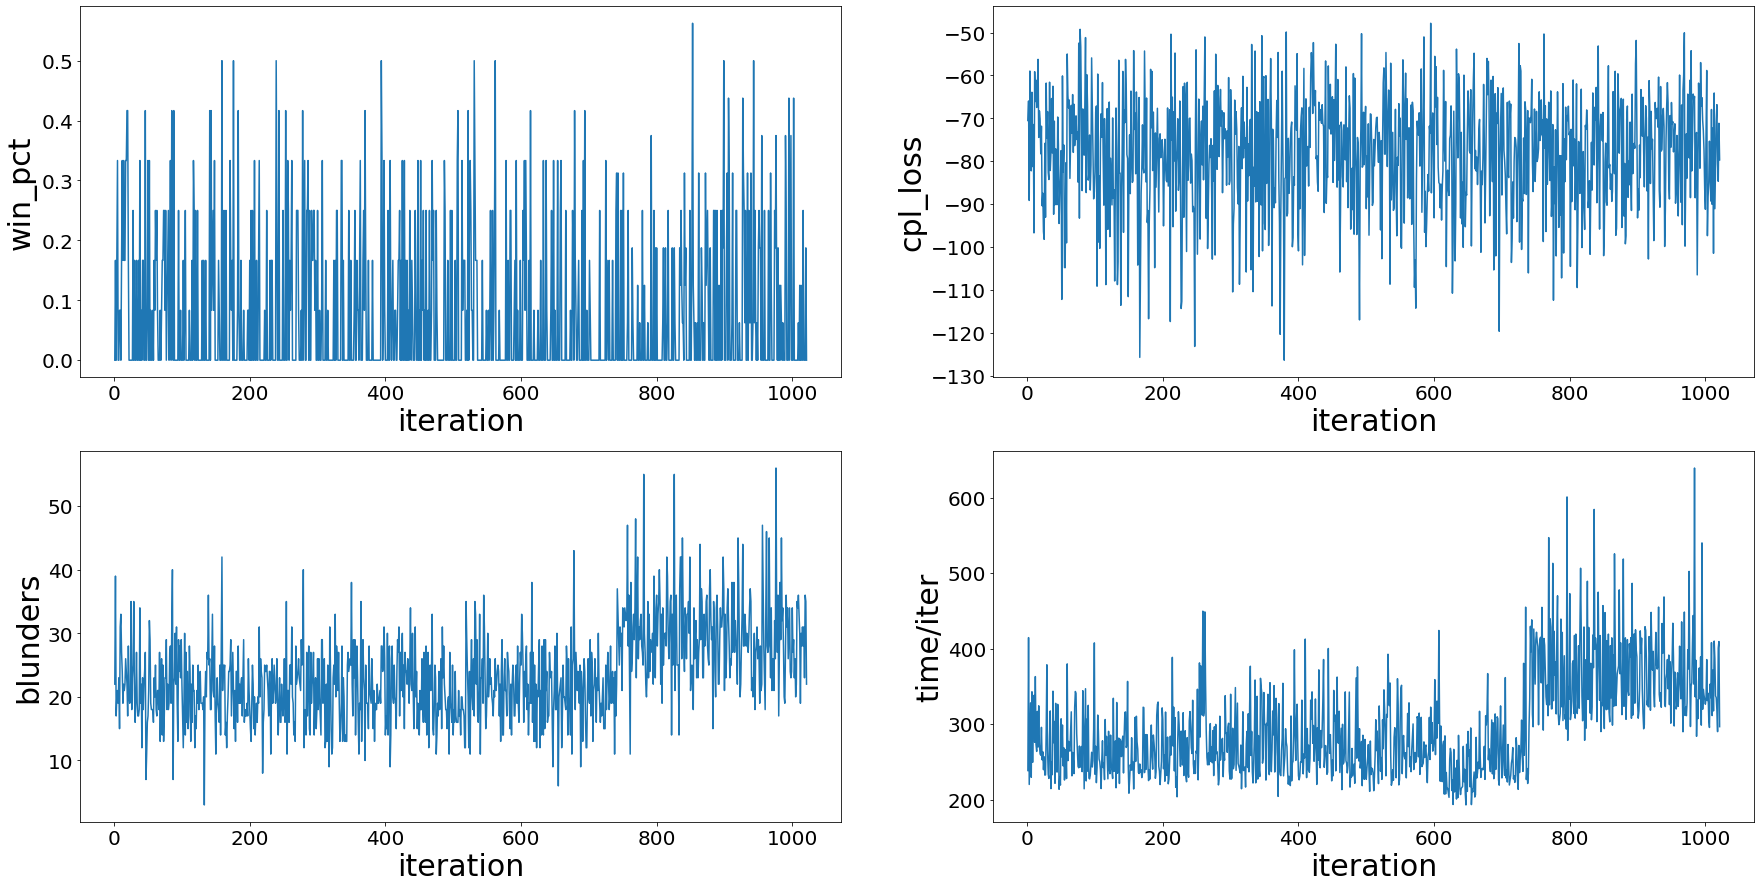

In [92]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(30,15))
ax[0,0].plot(output.iteration,output.win_pct)
ax[0,0].set_xlabel("iteration")
ax[0,0].set_ylabel("win_pct")

ax[0,1].plot(output.iteration,output.centipawn_loss_player1)
ax[0,1].set_xlabel("iteration")
ax[0,1].set_ylabel("cpl_loss")

ax[1,1].plot(output.iteration,output.time_per_iter)
ax[1,1].set_xlabel("iteration")
ax[1,1].set_ylabel("time/iter")

ax[1,0].plot(output.iteration,output.blunders_player1)
ax[1,0].set_xlabel("iteration")
ax[1,0].set_ylabel("blunders")

In [86]:
fig.savefig('reduced2.png')   # save the figure to file
plt.close(fig)    # close the figure window

In [29]:
board = chess.variant.AntichessBoard()
#board.set_fen("2bqk1nr/8/pppppppp/8/8/PPPPPPPP/8/2BQK1NR w - - 0 1")

In [31]:
board.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1'